# Flood model: estimation of the mean

January 2019

Copyright © EDF 2019


### References

* http://openturns.github.io/openturns/latest/examples/flood_model.html
* http://openturns.github.io/openturns/latest/theory/reliability_sensitivity/monte_carlo_simulation.html
* http://openturns.github.io/openturns/latest/user_manual/_generated/openturns.ExpectationSimulationAlgorithm.html



### Goal
* Compute the height of a river 

### Inputs
We consider four random variables : 
* Q : the flow rate ($m^3/s$)
* Ks : the Strickler coefficient ($m^{1/3}/s$)
* Zv : the upstream height of the riverbed (m)
* Zm : the downstream height of the riverbed (m)

### Notes : 
* When Ks increases, the riverbed generates less friction.
* We make the hypotheses that the random variables are independent.

### Paramètres

We consider the following parameters :
* the length of the river L = 5000 (m),
* the width of the river B = 300 (m).

### Sortie

The slope of the river is supposed to be close to zero :
$$
\alpha = \frac{Z_m - Z_v}{L},
$$
if $Z_m \geq Z_v$. 
We make the hypothesis that the height of the river is :
$$
H = \left(\frac{Q}{K_s B \sqrt{\alpha}}\right)^{0.6},
$$
for any $K_s, Q>0$.
Therefore, the height of the flood is :
$$
S = H + Z_v
$$

<img src="river_section_adjusted_light.png" width="400" />

### Distributions

We make the hypotheses that the input variables are *independent* and have the following distributions.

|Variable|Distribution|
| ------------- |-------------|
|Q|Gumbel(scale=558, mode=1013)>0|
|Ks|Normal(mean=30, standard deviation=7.5)>0|
|Zv|Uniform(min=49, max=51)|
|Zm|Uniform(min=54, max=56)|

### Quantity of interest

We want to estimate the mean of the height of the flood:
$$
E(S)
$$

## Script Python

We beging by importing the required modules.

In [1]:
from openturns.viewer import View
import openturns as ot
from math import sqrt
import pylab as pl

Then we define the function through which we want to propagate the uncertainties with the `def` operator.


In [2]:
def functionFlood(X) :
    L = 5.0e3
    B = 300.0
    Q, Ks, Zv, Zm = X
    alpha = (Zm - Zv)/L
    H = (Q/(Ks*B*sqrt(alpha)))**(3.0/5.0)
    S = H + Zv
    return [S]

Then we convert this Python function into an OpenTURNS function with the `PythonFunction` class. 

In [3]:
input_dimension = 4
g = ot.PythonFunction(input_dimension, 1, functionFlood)

Now we create the distributions for the input variables. 
* There are several ways to set the parameters of the Gumbel distribution for the Q variable. Here the parameters are defined with the scale and mode parameters, which corresponds to the `GumbelAB` class. 
* The Q and Ks variables must remain positive (a negative value is not compatible with the physical model). For this reason, we must truncate the distribution with  `TruncatedDistribution`. 

In [4]:
myParam = ot.GumbelAB(1013., 558.)
Q = ot.ParametrizedDistribution(myParam)
otLOW = ot.TruncatedDistribution.LOWER
Q = ot.TruncatedDistribution(Q, 0, otLOW)
Ks = ot.Normal(30.0, 7.5)
Ks = ot.TruncatedDistribution(Ks, 0, otLOW)
Zv = ot.Uniform(49.0, 51.0)
Zm = ot.Uniform(54.0, 56.0)

We set the descriptions of the random variables: they are used for the graphics.

In [5]:
Q.setDescription(["$Q (m^3/s)$"])
Ks.setDescription(["$Ks (m^{1/3})/s)$"])
Zv.setDescription(["Zv (m)"])
Zm.setDescription(["Zm (m)"])

The `drawPDF` presents the probability distribution function of the variable. When we closely look at the PDF of Q, we see a small increase of the density for Q=0, because of the truncation of the distribution.

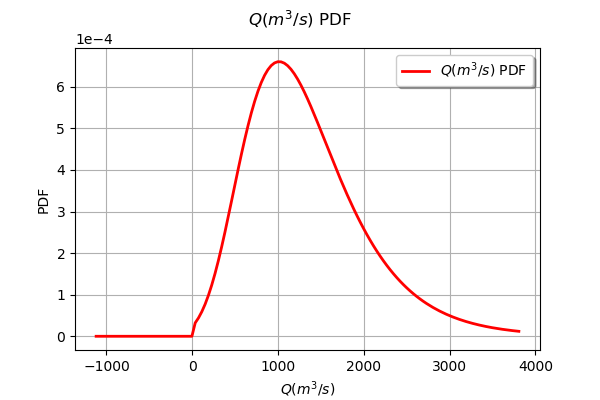

In [6]:
Q.drawPDF()

Then we create the input random vector `inputvector`: by default, the copula is independent. Then we create the output vector `S`.

In [7]:
X = ot.ComposedDistribution([Q, Ks, Zv, Zm])
inputRV = ot.RandomVector(X)
S = ot.RandomVector(g, inputRV)

## Estimate the mean with an incremental algorithm

In this section, we present how to use the `ExpectationSimulationAlgorithm` class. 

Assume that the output $Y\in\mathbb{R}^{n_Y}$ is a random vector and that we want to estimate the mean $E(Y)$. 

The Monte Carlo algorithm  with the sample mean : 
$$
\overline{Y} = \frac{1}{n} \sum_{i=1}^n Y_i
$$
where $n$ is the sample size and $Y_i$ are i.i.d. realization of the output. 

We use the fact that the sample mean is asymptotically gaussian :
$$
\overline{Y} \sim \mathcal{N}\left(E(Y),\frac{V(Y)}{n}\right).
$$
where $V(Y)$ is the variance of the output and $n$ is the sample size.

In general, most users set the sample size $n$ in advance and estimate the precision afterwards. Instead, suppose that if set the absolute precision and wish to determine the smallest sample size that achieves this precision. If we knew the variance $V(Y)$, we could set the value of $n$ so that the standard deviation $\sqrt{V(Y)}$ would be small enough. If instead we want to set the relative precision, we could consider the coefficient of variation $\frac{\sqrt{V(Y)}}{E(Y) \sqrt{n}}$ as a criterion (if $E(Y)\neq 0$). The purpose of the algorithm is to increase the sample size $n$ incrementally until a stopping criteria is met. 

This algorithm works by updating a sample which size increases progressively until a stopping criteria is met. In order to get the best possible performance on distributed supercomputers and multi-core workstations, the size of the sample increases by block. For exemple, if the block size is equal to 100, then the sample size will be equal to 0, 100, 200, etc... On each block, the evaluation of the outputs can be parallelized, which allows to improve the performance of the algorithm.

There are three mathematical stopping criteria available:
* through an operator on the coefficient of variation $\frac{\sigma_i}{\mu_i}$ (a relative criterion)
* through an operator on the standard deviation $\sigma_i$ (absolute criterion)
* on the maximum standard deviation per component: $\sigma_i \leq \max_{i=1,...,n_Y} \sigma_i$ (absolute criterion)

By default, the maximum coefficient of variation is used, i.e. the algorithm stops when: 
$$
\max_{i=1,...,n_Y} \frac{\sigma_i}{\mu_i} \leq max_{COV}.
$$

In [8]:
ot.RandomGenerator.SetSeed(0)
algo = ot.ExpectationSimulationAlgorithm(S)
algo.setMaximumOuterSampling(1000)
algo.setBlockSize(10)
algo.setMaximumCoefficientOfVariation(0.001)
algo.run()
result = algo.getResult()
expectation = result.getExpectationEstimate()
print("Mean = %f " % expectation[0])
print("Number of calls to G = %d" % g.getCallsNumber())
cv = result.getCoefficientOfVariation()[0]
print("Coef. of var.=%.6f" % (cv))

Mean = 52.520729 
Number of calls to G = 500
Coef. of var.=0.000994


The estimate of the mean has a known asymptotical gaussian distribution, which can be retrieved with the `getExpectationDistribution` method. 

Normal(mu = 52.5207, sigma = 0.0522269)


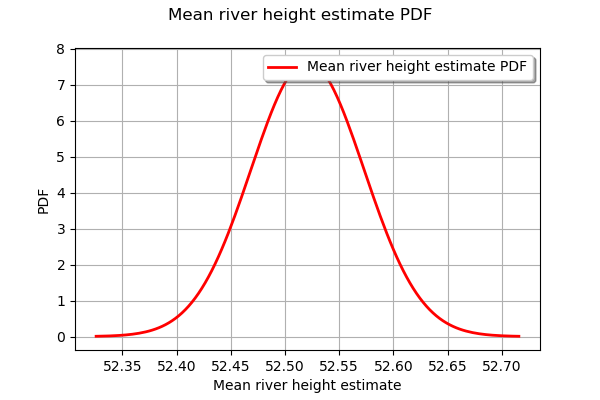

In [9]:
expectationDistribution = result.getExpectationDistribution()
expectationDistribution.setDescription(["Mean river height estimate"])
print(expectationDistribution)
expectationDistribution.drawPDF()

## Estimate sensitivity indices with an incremental algorithm



In order to estimate the Sobol' sensitivity indices, we can use the `SobolSimulationAlgorithm` class. 

###  Principle 

Let us denote by $X\in\mathbb{R}^{n_X}$ a random vector. This algorithm works in the general case where the output $Y\in\mathbb{R}^{n_Y}$ is a random vector : in this case it operates on aggregated indices. In order to simplify the discussion, let us make the hypothesis that $n_Y=1$. 

The Sobol' first order sensitivity indices are defined by 
$$
S_i = \frac{V(E(Y|X_i))}{V(Y)}
$$
for $i=1,...,n_X$. The total order sensitivity indices are defined by :
$$
T_i = 1 - \frac{V\left(E\left(Y|X_{-i}\right)\right)}{V(Y)}
$$
where $-i$ is the set of indices which are different from $i$. In the remaining of this section, we focus on the first order sensitivity indice and let the reader consider [1] for the total order indices. Moreover, the derivation is the same for all input variables so that we omit the indice $i$ in order to simplify the notations. 

### Asymptotic distribution
The algorithm is based on the fact that the first and total order Sobol' sensitivity indices asymptotically have the gaussian distribution. This gaussian distribution can be derived from the so called "delta"-method. Assume that the Sobol' estimator is 
$$
\overline{S} = \Psi\left(\overline{U}\right)
$$
where $\Psi$ is a multivariate function, $U$ is a multivariate sample and $\overline{U}$ is its sample mean. Each Sobol' estimator can be associated with a dedicated choice of function $\Psi$ and vector $U$. 

Let us denote by $\Phi_j^F$ (resp. $\Phi_j^T$) the cumulated distribution function of the gaussian distribution of the first (resp. total) order sensitivity indice of the j-th input variable.

Each available estimator in the library provides its own distribution :
* Saltelli
* MauntzKucherenko
* Jansen
* Martinez

### Stopping criteria
We set $\alpha\in[0,1]$ the level of the confidence interval and $\epsilon \in(0,1]$ the length of the confidence interval. The algorithms stops when, on all components, one of the two following conditions are satisfied :
* first and total order indices haved been estimated with enough precision or 
* the first order indices are separable from the total order indices. 

The precision is said to be sufficient if the $1-2\alpha$ confidence interval is smaller than $\epsilon$ :
$$
(\Phi_j^F)^{-1}(1-\alpha) - (\Phi_j^F)^{-1}(\alpha) \leq \epsilon
$$
and 
$$
(\Phi_j^T)^{-1}(1-\alpha) - (\Phi_j^T)^{-1}(\alpha) \leq \epsilon
$$
for $j=1,...,n_X$.  
The first order indices are *separable* from the total order indices if 
$$
\Phi_j^F(1-\alpha) \leq \Phi_j^T(\alpha)
$$
for $j=1,...,n_X$.  


### Performance

At each iteration a fixed number 
$$
N = blocksize \times (n_X + 2)
$$
of replications inputs is generated. These inputs are evaluated by blocks of size $batchsize$ through the model f. This allows to make use of parallel resources and to increase the performance of the algorithm, if possible.

In [10]:
alpha = 0.05 # i.e. 90% confidence interval
epsilon = 0.2 # Confidence interval length
blocksize = 50 # size of Sobol experiment at each iteration
batchsize = 16 # number of points evaluated simultaneously

In [11]:
estimator = ot.SaltelliSensitivityAlgorithm()
estimator.setUseAsymptoticDistribution(True)
algo = ot.SobolSimulationAlgorithm(X, g, estimator)
algo.setMaximumOuterSampling(100) # number of iterations
algo.setBlockSize(blocksize) 
algo.setBatchSize(batchsize) 
algo.setIndexQuantileLevel(alpha) # alpha
algo.setIndexQuantileEpsilon(epsilon) # epsilon
algo.run()

In [12]:
result = algo.getResult()
fo = result.getFirstOrderIndicesEstimate()
to = result.getTotalOrderIndicesEstimate()
print("First order = %s" % (str(fo)))
print("Total order = %s" % (str(to)))

First order = [0.529059,0.205321,0.381215,0.0316592]
Total order = [0.481355,0.130565,0.362292,0.011206]


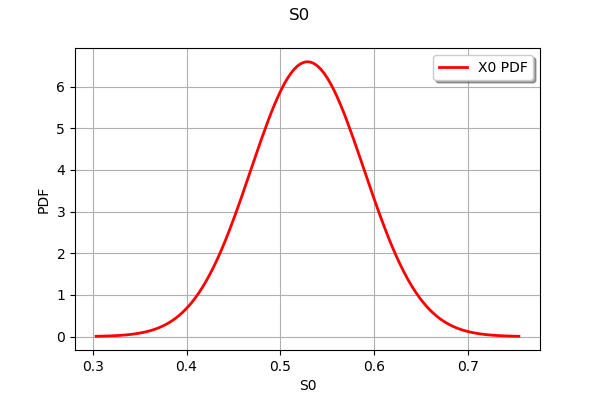

In [17]:
dist_fo = result.getFirstOrderIndicesDistribution()
dist_fo_i = dist_fo.getMarginal(0)
graph = dist_fo_i.drawPDF()
graph.setTitle("S0")
graph.setXTitle("S0")
graph

X0, S in [0.4296,0.6285] (len=0.1988), ST in [0.4281,0.5346] (len=0.1065)
X1, S in [0.1056,0.3050] (len=0.1994), ST in [0.0906,0.1705] (len=0.0799)
X2, S in [0.3132,0.4492] (len=0.1360), ST in [0.3193,0.4053] (len=0.0860)
X3, S in [-0.0244,0.0877] (len=0.1121), ST in [0.0026,0.0198] (len=0.0171)


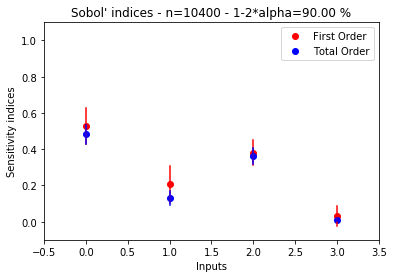

In [14]:
pl.plot(range(input_dimension),fo,"ro",label="First Order")
pl.plot(range(input_dimension),to,"bo",label="Total Order")
pl.xlabel("Inputs")
pl.ylabel("Sensitivity indices")
size = g.getEvaluationCallsNumber()
pl.title("Sobol' indices - n=%d - 1-2*alpha=%.2f %%" % (size,(1-2*alpha)*100))
pl.axis([-0.5,input_dimension-0.5,-0.1,1.1])
for i in range(input_dimension):
    dist_fo_i = dist_fo.getMarginal(i)
    dist_to_i = dist_to.getMarginal(i)
    fo_ci = dist_fo_i.computeBilateralConfidenceInterval(1-2*alpha)
    to_ci = dist_to_i.computeBilateralConfidenceInterval(1-2*alpha)
    fo_ci_a = fo_ci.getLowerBound()[0]
    fo_ci_b = fo_ci.getUpperBound()[0]
    to_ci_a = to_ci.getLowerBound()[0]
    to_ci_b = to_ci.getUpperBound()[0]
    # Confidence interval length
    fo_cilength = fo_ci_b - fo_ci_a 
    to_cilength = to_ci_b - to_ci_a
    print("X%d, S in [%.4f,%.4f] (len=%.4f), ST in [%.4f,%.4f] (len=%.4f)" % (i,fo_ci_a,fo_ci_b,fo_cilength,to_ci_a,to_ci_b,to_cilength))
    pl.plot([i,i],[fo_ci_a,fo_ci_b],"r-")
    pl.plot([i,i],[to_ci_a,to_ci_b],"b-")
pl.legend()

The following script plots the gaussian distribution of the estimate of the first order Sobol' indice.

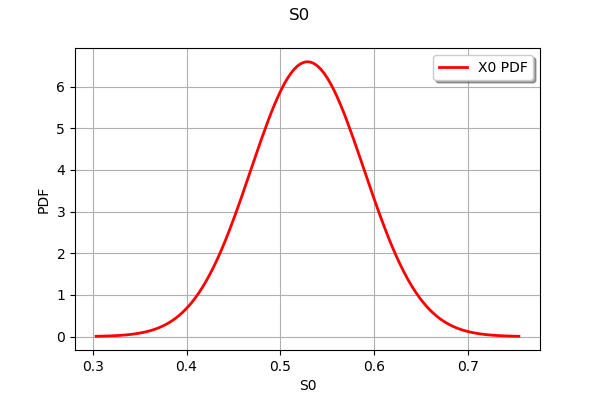